In [1]:
# generic import
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools as iter
import scipy as sc

# mne import
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne import set_log_level

# pyriemann import
import pyriemann
from pyriemann.classification import MDM, TSclassifier, class_distinctiveness
from pyriemann.estimation import Covariances, Coherences
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.embedding import SpectralEmbedding
from pyriemann.transfer import encode_domains, decode_domains, TLCenter, TLStretch, TLRotate
from pyriemann.utils.mean import mean_covariance
from pyriemann.clustering import Kmeans

# sklearn imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, BaseCrossValidator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

import itertools

set_log_level(verbose=False)

In [24]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec  3 15:55:26 2017

@author: https://gist.github.com/fasiha/fdb5cec2054e6f1c6ae35476045a0bbd
"""

from numpy import linalg as la
import numpy as np
    
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

def nearestPD(A, y=None, sample_weight=None):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def ensemble_cross_val_score(clf, ppl_fc, X1, X2, y, cv):
    n_classes = np.unique(y).shape[0]
    X_stacked_train = np.empty((X1.shape[0], 2 * n_classes))
    for train_idx, test_idx in cv.split(X1, y):
        X1_train_fold, X1_test_fold = X1[train_idx], X1[test_idx]
        X2_train_fold, X2_test_fold = X2[train_idx], X2[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]

        # Fit the base models on the training fold
        ppl_fc['cov'].fit(X1_train_fold, y_train_fold)
        ppl_fc['instantaneous'].fit(X2_train_fold, y_train_fold)

        # Make predictions on the validation fold
        pred1 = ppl_fc['cov'].predict_proba(X1_test_fold)
        pred2 = ppl_fc['instantaneous'].predict_proba(X2_test_fold)
        
        # Stack predictions on the validation fold
        X_stacked_train[test_idx, :n_classes] = pred1
        X_stacked_train[test_idx, n_classes:] = pred2
        
    # Fit the stacking classifier on the stacked predictions
    clf.fit(X_stacked_train, y)

    # Make predictions on the entire dataset for evaluation
    pred_stacking = clf.predict(X_stacked_train)

    # Evaluate the stacking classifier
    return accuracy_score(y, pred_stacking)

class ExchangeKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y, groups=None):
        indices = np.arange(len(X))
        if self.shuffle:
            rng = np.random.default_rng(self.random_state)
            rng.shuffle(indices)

        fold_sizes = np.full(self.n_splits, len(X) // self.n_splits, dtype=int)
        fold_sizes[:len(X) % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            yield indices[start:stop], [i for i in range(len(X)) if (i < start or i >= stop)]
            current = stop

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

def ensemble_cross_val_score(clf, ppl_fc, X1, X2, y, cv):
    n_classes = np.unique(y).shape[0]
    X_stacked_train = np.empty((X1.shape[0], 2 * n_classes))
    for train_idx, test_idx in cv.split(X1, y):
        X1_train_fold, X1_test_fold = X1[train_idx], X1[test_idx]
        X2_train_fold, X2_test_fold = X2[train_idx], X2[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]

        # Fit the base models on the training fold
        ppl_fc['cov'].fit(X1_train_fold, y_train_fold)
        ppl_fc['instantaneous'].fit(X2_train_fold, y_train_fold)

        # Make predictions on the validation fold
        pred1 = ppl_fc['cov'].predict_proba(X1_test_fold)
        pred2 = ppl_fc['instantaneous'].predict_proba(X2_test_fold)
        
        # Stack predictions on the validation fold
        X_stacked_train[test_idx, :n_classes] = pred1
        X_stacked_train[test_idx, n_classes:] = pred2
        
    # Fit the stacking classifier on the stacked predictions
    clf.fit(X_stacked_train, y)

    # Make predictions on the entire dataset for evaluation
    pred_stacking = clf.predict(X_stacked_train)

    # Evaluate the stacking classifier
    return accuracy_score(y, pred_stacking)

def ensemble_score(clf, ppl_fc, X1, X2, y, test_X1, test_X2, test_y):
    n_classes = np.unique(y).shape[0]
    X_stacked_train = np.empty((X1.shape[0], 2 * n_classes))
    X_stacked_test = np.empty((test_X1.shape[0], 2 * n_classes))

    # Fit the base models on the training fold
    ppl_fc['cov'].fit(X1, y)
    ppl_fc['instantaneous'].fit(X2, y)

    # Make predictions on the validation fold
    pred1 = ppl_fc['cov'].predict_proba(X1)
    pred2 = ppl_fc['instantaneous'].predict_proba(X2)
        
    # Stack predictions on the validation fold
    X_stacked_train[:, :n_classes] = pred1
    X_stacked_train[:, n_classes:] = pred2

    # Make predictions on the validation fold
    pred1 = ppl_fc['cov'].predict_proba(test_X1)
    pred2 = ppl_fc['instantaneous'].predict_proba(test_X2)
        
    # Stack predictions on the validation fold
    X_stacked_test[:, :n_classes] = pred1
    X_stacked_test[:, n_classes:] = pred2
        
    #y = np.concatenate((y, test_y))
    # Fit the stacking classifier on the stacked predictions
    clf.fit(X_stacked_train, y)

    # Make predictions on the entire dataset for evaluation
    pred_stacking = clf.predict(X_stacked_test)

    # Evaluate the stacking classifier
    return accuracy_score(test_y, pred_stacking)

In [16]:
import pickle as pk

selected_events = None
inconsistent_session = False

# ====================================
# ======== Schirrmeister2017 =========
# ====================================

subjects = [i+1 for i in range(2)] # 14
sessions = ["0"]
runs = ["0train", "1test"]
#runs = ["0train"]
tmin, tmax = 1., 3.
sample_step = 3 # chan = 128
dispersion_1 = 50
dispersion_2 = 1000
dispersion_3 = 100

n_subjects = len(subjects)
n_sessions = [[320,480-320], # 1
              [831,973-831], # 2
              [880,1040-880], # 3
              [897,1057-897], # 4
              [720,880-720], # 5
              [880,1040-880], # 6
              [880,1040-880], # 7
              [654,814-654], # 8
              [880,1040-880], # 9
              [880,1040-880], # 10
              [880,1040-880], # 11
              [880,1040-880], # 12
              [800,960-800], # 13
              [880,1040-880] # 14
             ]

n_subjects = len(subjects)
n_runs = len(runs)

all_epochs = []
all_labels = []

epoch_path = "./epoch_data"

for i, sub in enumerate(subjects):
    try:
        with open(f"{epoch_path}/sch_{sub}_epoch.pkl", 'rb') as f:
            all_epochs.append(pk.load(f))
        with open(f"{epoch_path}/sch_{sub}_label.pkl", 'rb') as f:
            all_labels.append(pk.load(f))
    except:
        print("Please execute mDA_Schirrmeister_preprocess.ipynb first.")

In [ ]:
# mDA main loop

align_methods = ['rct-4+8', 'rct-4+8+16', 'rct-4', 'rct-8', 'rct-16', 'rct-2000',
                 'rpa-4+8', 'rpa-4+8+16', 'rpa-4', 'rpa-8', 'rpa-16', 'rpa-2000']

separability_scores = ['dis', 'fis', 'sil', 'db']        

#conn_types = ['cov', 'lagged', 'instantaneous']
conn_types = ['cov', 'instantaneous']
all_conn = {c: [] for c in conn_types}

all_align_conn = {c: {a: [] for a in align_methods} for c in conn_types}
all_align_label = {c: {a: [] for a in align_methods} for c in conn_types}
all_align_cluster = {c: [] for c in conn_types}
all_n_align_cluster = {c: [] for c in conn_types}

all_score = {}

all_dis_scores = {c: {a: [] for a in align_methods} for c in conn_types}
all_dis_scores_1 = {c: {a: [] for a in align_methods} for c in conn_types}
all_fis_scores = {c: {a: [] for a in align_methods} for c in conn_types}
all_fis_scores_1 = {c: {a: [] for a in align_methods} for c in conn_types}
all_sil_scores = {c: {a: [] for a in align_methods} for c in conn_types}
all_sil_scores_1 = {c: {a: [] for a in align_methods} for c in conn_types}
all_db_scores = {c: {a: [] for a in align_methods} for c in conn_types}
all_db_scores_1 = {c: {a: [] for a in align_methods} for c in conn_types}

for i, subject in enumerate(subjects):
    print(f"Processing subject {subject}...")
    
    dis_scores = []
    dis_scores_1 = []
    fis_scores = []
    fis_scores_1 = []
    sil_scores = []
    sil_scores_1 = []
    db_scores = []
    db_scores_1 = []
    
    # get epochs
    epochs_data = 1e6 * all_epochs[i].get_data()
    labels = all_labels[i]
    trial_labels = all_labels[i][1::2]
    
    for conn_type in conn_types:
        
        all_align_cluster[conn_type].append([])
        all_n_align_cluster[conn_type].append([])
        
        if conn_type == 'cov':
            # compute covariance matrices
            conn = Covariances().transform(epochs_data)
        else:
            conn = Coherences(coh=conn_type, fmin=7., fmax=35., fs=500.0).transform(epochs_data)
            conn = np.mean(conn, axis=-1, keepdims=False)
        
        conn = np.array(list(map(nearestPD, conn)))
    
        all_conn[conn_type].append(conn)
        trial_conn = conn[1::2]
    
        print(f"conn_type = {conn_type}\nconn.shape = {conn.shape}")
    
        session_cluster = np.concatenate([np.repeat(np.array([j]), n) for j, n in enumerate(n_sessions[subject-1])])
        print(session_cluster)
        
        # Align sessions/sub-sessions by recentering and stretching
        align_ind = 0
        for m in align_methods:
            
            window = m.split('-')[-1]
            if '+' in window:
                print("Multi-fold mDA with windows: ", window.split('+'))
                windows = list(map(int, window.split('+')))
                X_centered_list = []
                
                for window in windows:
                    domains = []
                    y = []
                    X = []
                    
                    for c in np.unique(session_cluster):
                        index = np.where(session_cluster == c)[0]

                        step = int(np.round(len(index) / window - 0.01))
                        for start in range(step):
                            start_i = start*window
                            end_i = min(len(index),(start+1)*window)
                            if start == step - 1:
                                end_i = len(index)
                            for j in index[start_i:end_i]:
                                domains.append(f'domain-{c}-{window}-{start}')
                                y.append(trial_labels[j])
                                X.append(trial_conn[j])
                                
                    print("Domain: ", domains)
                    
                    X = np.array(X)
                    y = np.array(y)
                    null_y = np.zeros(y.shape)

                    X_enc, y_enc = encode_domains(X, null_y, domains)
                    tlc = TLCenter(domains[0], metric='riemann')
                    X_centered = tlc.fit_transform(X_enc, y_enc)
                    if 'rpa' in m:
                        tls = TLStretch(domains[0], final_dispersion=dispersion_2, centered_data=True, metric='riemann')
                        X_centered = tls.fit_transform(X_centered, y_enc)

                    X_centered_list.append(X_centered)
                    
                X_centered = np.array(list(map(mean_covariance, 
                                               np.array([[X_centered_list[i_w][i_x] for i_w in range(len(windows))] 
                                                for i_x in range(len(X_centered_list[0]))]))))
                            
            else:
                print("Single-fold mDA with window: ", window)
                window = int(window)
                
                domains = []
                y = []
                X = []

                for c in np.unique(session_cluster):
                    index = np.where(session_cluster == c)[0]

                    step = max(1, int(np.round(len(index) / window - 0.01)))
                    for start in range(step):
                        start_i = start*window
                        end_i = min(len(index),(start+1)*window)
                        if start == step - 1:
                            end_i = len(index)
                        for j in index[start_i:end_i]:
                            domains.append(f'domain-{c}-{window}-{start}')
                            y.append(trial_labels[j])
                            X.append(trial_conn[j])
                

                print("Domain: ", domains)
                
                X = np.array(X)
                y = np.array(y)
                null_y = np.zeros(y.shape)

                X_enc, y_enc = encode_domains(X, null_y, domains)
                tlc = TLCenter(domains[0], metric='riemann')
                X_centered = tlc.fit_transform(X_enc, y_enc)
                if 'rpa' in m:
                    tls = TLStretch(domains[0], final_dispersion=dispersion_2, centered_data=True, metric='riemann')
                    X_centered = tls.fit_transform(X_centered, y_enc)

            all_align_conn[conn_type][m].append(X_centered)
            all_align_label[conn_type][m].append(trial_labels)
            
            # record separability
            all_dis_scores[conn_type][m].append(class_distinctiveness(X, y, exponent=1, return_num_denom=True))
            all_dis_scores_1[conn_type][m].append(class_distinctiveness(X_centered, y, exponent=1, return_num_denom=True))

            all_fis_scores[conn_type][m].append(class_distinctiveness(X, y, exponent=2, return_num_denom=True))
            all_fis_scores_1[conn_type][m].append(class_distinctiveness(X_centered, y, exponent=2, return_num_denom=True))

            n_components = 2
            spec = SpectralEmbedding(n_components=n_components)
            embeddings = spec.fit_transform(X)
            embeddings_1 = spec.fit_transform(X_centered)

            all_sil_scores[conn_type][m].append(silhouette_score(embeddings, y))
            all_sil_scores_1[conn_type][m].append(silhouette_score(embeddings_1, y))

            all_db_scores[conn_type][m].append(davies_bouldin_score(embeddings, y))
            all_db_scores_1[conn_type][m].append(davies_bouldin_score(embeddings_1, y))

Processing subject 1...


/tmp/ipykernel_2775/1378682832.py:40: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = 1e6 * all_epochs[i].get_data()


conn_type = cov
conn.shape = (960, 43, 43)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Single-fold mDA with window:  4
Domain:  ['domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-4', 'domain-0-4-4', 'domain-0-4-4', 'domain-0-4-4', 'domain-0-4-5', 'domain-0-4-5', 'domain-0-4-5', 'domain-0-4-5', 'domain-0-4-6', 'domain-0-4-6', 'domain-0-4-6', 'domain-0-4-6', 'domain-0-4-7', 'domain-0-4-7', 'domain-0-4-7', 'domain-0-4-7', 'domain-0-4-8', 'domain-0-4-8', 'domain-0-4-8', 'domain-0-4-8', 'domain-0-4-9', 'domain-0-4-9', 'domain-0-4-9', 'domain-0-4-9', 'domain-0-4-10', 'domain-0-4-10', 'domain-0-4-10', 'domain-0-4-10', 'domain-0-4-11', 'domain-0-4-11', 'domain-0-4-11', 'domain-0-4-11', 'domain-0-4-12', 'domain-0-4-12', 'domain-0-4-12', 'domain-0-4-12', 'domain-0-4-13', 'domain-0-4-13', 'domain-0-4-13', 'domain-0-4-13', 'domain-0-4-14', 'domain-0-4-14', 'domain-0-4-

/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Single-fold mDA with window:  4
Domain:  ['domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-4', 'domain-0-4-4', 'domain-0-4-4', 'domain-0-4-4', 'domain-0-4-5', 'domain-0-4-5', 'domain-0-4-5', 'domain-0-4-5', 'domain-0-4-6', 'domain-0-4-6', 'domain-0-4-6', 'domain-0-4-6', 'domain-0-4-7', 'domain-0-4-7', 'domain-0-4-7', 'domain-0-4-7', 'domain-0-4-8', 'domain-0-4-8', 'domain-0-4-8', 'domain-0-4-8', 'domain-0-4-9', 'domain-0-4-9', 'domain-0-4-9', 'domain-0-4-9', 'domain-0-4-10', 'domain-0-4-10', 'domain-0-4-10', 'domain-0-4-10', 'domain-0-4-11', 'domain-0-4-11', 'domain-0-4-11', 'domain-0-4-11', 'domain-0-4-12', 'domain-0-4-12', 'domain-0-4-12', 'domain-0-4-12', 'domain-0-4-13', 'domain-0-4-13', 'domain-0-4-13', 'domain-0-4-13', 'domain-0-4-14', 'domain-0-4-14', 'domain-0-4-

/tmp/ipykernel_2775/1378682832.py:40: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = 1e6 * all_epochs[i].get_data()


conn_type = cov
conn.shape = (1946, 43, 43)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Domain:  ['domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-7', 'domain-0-8-7', 'domain-0-8-7', 'domain-0-8-7', 'domain-0-8-7', 'domain-0-8-7'

/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Domain:  ['domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-2', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-3', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-4', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-5', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-6', 'domain-0-8-7', 'domain-0-8-7', 'domain-0-8-7', 'domain-0-8-7', 'domain-0-8-7', 'domain-0-8-7'

/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


In [31]:
# Classifier
# MDM
clf1 = MDM(metric=dict(mean='riemann', distance='riemann'))

# TSLR
clf2 = TSclassifier()

# CSP+LR
lr = LogisticRegression()
csp = pyriemann.spatialfilters.CSP(nfilter=6)
clf3 = Pipeline([('CSP', csp), ('LogisticRegression', lr)])

# CSP+OptSVM
csp = CSP(nfilter=6)
param_svm = {"kernel": ("linear", "rbf"), "C": [0.1, 1, 10]}
optSVM = GridSearchCV(SVC(), param_svm, cv=3)
clf4 = Pipeline([('CSP', csp), ('OptimalSVM', optSVM)])

# FUCONE
param_lr = {
    "penalty": "elasticnet",
    "l1_ratio": 0.15,
    "intercept_scaling": 1000.0,
    "solver": "saga",
}
ppl_fc = {}
for _, conn_type in enumerate(conn_types):
    ppl_fc[conn_type] = Pipeline(
        steps=[
               ("tg", TangentSpace(metric="riemann")),
               ("LogistReg", LogisticRegression(**param_lr))
               #("TSLR", TSclassifier())
              ])
clf5 = Pipeline([('lr', LogisticRegression(**param_lr))])

# cross validation

# Offline supervised learning
# Typical 5-fold cross-validation (80% training and 20% testing)
#cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Offline few-shot supervised learning
# Exchange the training and testing set for typical 5-fold cross-validation (20% training and 80% testing)
#cv = ExchangeKFold(n_splits=5, shuffle=True, random_state=42)

# Offline supervised learning for cross-session generalization
# (train on one session and test on all the other sessions)
# n-fold cross-validation where n is the number of session for each subject
#cv = KFold(n_splits=n_sessions, shuffle=False)

# Offline few-shot supervised learning for cross-session generalization
# (train on one session and test on all the other sessions)
# n-fold cross-validation where n is the number of session for each subject
#cv = ExchangeKFold(n_splits=n_sessions, shuffle=False)

# Offline supervised learning for cross-subject generalization
# (train on one subject and test on all the other subjects)
# n-fold cross-validation where n is the number of subject in the dataset
#cv = KFold(n_splits=n_subjects, shuffle=False)

# Offline few-shot supervised learning for cross-subject generalization
# (train on one subject and test on all the other subjects)
# n-fold cross-validation where n is the number of subject in the dataset
#cv = ExchangeKFold(n_splits=n_subjects, shuffle=False)

# Train on the first session, test on the remaining sessions
#cv = TimeSeriesSplit(n_splits=2, max_train_size=20,test_size=20)

cv_list = {
           "cross-session": None,
           "within-subject": KFold(n_splits=5, shuffle=True, random_state=42),
           "cross-subject": None
          }

decoding_algo = ['mdm', 'tslr', 'csp+lr', 'csp+optsvm', 'fucone']

overall_acc = {s: {m: {algo: [] for algo in decoding_algo}
               for m in align_methods} for s in cv_list}

for scenario, cv in cv_list.items():
    for i, subject in enumerate(subjects):
        print(f"Classifying subject {subject} under scenario {scenario}...")
        
        if scenario == "cross-subject":
            if i > 0:
                print("No need to loop for cross-subject")
                break

        n_samples = all_conn['cov'][i][1::2].shape[0]

        # Compute class balance
        class_balance = np.mean(all_labels[i][1::2] == all_labels[i][1::2][0])
        class_balance = max(class_balance, 1. - class_balance)

        if scenario == "within-subject":
            for j, m in enumerate(align_methods):
                print(f'Method: {m}')
                
                X1 = all_align_conn['cov'][m][i]
                X2 = all_align_conn['instantaneous'][m][i]
                y = all_align_label['cov'][m][i]
    
                # Use scikit-learn Pipeline with cross_val_score function
                scores1 = cross_val_score(clf1, X1, y, cv=cv, n_jobs=1)
                scores2 = cross_val_score(clf2, X1, y, cv=cv, n_jobs=1)
                scores3 = cross_val_score(clf3, X1, y, cv=cv, n_jobs=1)
                scores4 = cross_val_score(clf4, X1, y, cv=cv, n_jobs=1)
                scores5 = ensemble_cross_val_score(clf5, ppl_fc, X1, X2, y, cv)
    
                overall_acc[scenario][m]['mdm'].append(np.mean(scores1))
                overall_acc[scenario][m]['tslr'].append(np.mean(scores2))
                overall_acc[scenario][m]['csp+lr'].append(np.mean(scores3))
                overall_acc[scenario][m]['csp+optsvm'].append(np.mean(scores4))
                overall_acc[scenario][m]['fucone'].append(np.mean(scores5))
                # Print the results
                print(f"Classification accuracy: {np.mean(scores1):.4f} / {np.mean(scores2):.4f} / {np.mean(scores3):.4f} / {np.mean(scores4):.4f} / {np.mean(scores5):.4f}, Chance level: {class_balance:.4f}")
                
        elif scenario == "cross-session":
            for j, m in enumerate(align_methods):
                print(f'Method: {m}')
                train_X1 = all_align_conn['cov'][m][i][:n_sessions[i][0]]
                test_X1 = all_align_conn['cov'][m][i][n_sessions[i][0]:]
                train_X2 = all_align_conn['instantaneous'][m][i][:n_sessions[i][0]]
                test_X2 = all_align_conn['instantaneous'][m][i][n_sessions[i][0]:]
                train_y = all_align_label['cov'][m][i][:n_sessions[i][0]]
                test_y = all_align_label['cov'][m][i][n_sessions[i][0]:]
                
                scores1 = clf1.fit(train_X1, train_y).score(test_X1, test_y)
                scores2 = clf2.fit(train_X1, train_y).score(test_X1, test_y)
                scores3 = clf3.fit(train_X1, train_y).score(test_X1, test_y)
                scores4 = clf4.fit(train_X1, train_y).score(test_X1, test_y)
                scores5 = ensemble_score(clf5, ppl_fc, train_X1, train_X2, train_y, test_X1, test_X2, test_y)
    
                overall_acc[scenario][m]['mdm'].append(np.mean(scores1))
                overall_acc[scenario][m]['tslr'].append(np.mean(scores2))
                overall_acc[scenario][m]['csp+lr'].append(np.mean(scores3))
                overall_acc[scenario][m]['csp+optsvm'].append(np.mean(scores4))
                overall_acc[scenario][m]['fucone'].append(np.mean(scores5))
    
                print(f"Classification accuracy: {np.mean(scores2):.4f} / {np.mean(scores5):.4f}, Chance level: {class_balance:.4f}")
        
        else:
            for j, m in enumerate(align_methods):
                print(f'Method: {m}')
                for iite, ss in enumerate(subjects):
                    train_X1 = np.concatenate([all_align_conn['cov'][m][ite] for ite, s in enumerate(subjects) if s != ss])
                    test_X1 = all_align_conn['cov'][m][iite]
                    train_X2 = np.concatenate([all_align_conn['instantaneous'][m][ite] for ite, s in enumerate(subjects) if s != ss])
                    test_X2 = all_align_conn['instantaneous'][m][iite]
                    train_y = np.concatenate([all_align_label['cov'][m][ite] for ite, s in enumerate(subjects) if s != ss])
                    test_y = all_align_label['cov'][m][iite]
    
                    scores1 = clf1.fit(train_X1, train_y).score(test_X1, test_y)
                    scores2 = clf2.fit(train_X1, train_y).score(test_X1, test_y)
                    scores3 = clf3.fit(train_X1, train_y).score(test_X1, test_y)
                    scores4 = clf4.fit(train_X1, train_y).score(test_X1, test_y)
                    scores5 = ensemble_score(clf5, ppl_fc, train_X1, train_X2, train_y, test_X1, test_X2, test_y)
        
                    overall_acc[scenario][m]['mdm'].append(np.mean(scores1))
                    overall_acc[scenario][m]['tslr'].append(np.mean(scores2))
                    overall_acc[scenario][m]['csp+lr'].append(np.mean(scores3))
                    overall_acc[scenario][m]['csp+optsvm'].append(np.mean(scores4))
                    overall_acc[scenario][m]['fucone'].append(np.mean(scores5))
        
                    print(f"Classification accuracy: {np.mean(scores2):.4f} / {np.mean(scores5):.4f}, Chance level: {class_balance:.4f}")

Classifying subject 1 under scenario cross-session...
Method: rpa-4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8562 / 0.8375, Chance level: 0.7500
Method: rpa-4+8+16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8500 / 0.8375, Chance level: 0.7500
Method: rpa-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8375 / 0.8500, Chance level: 0.7500
Method: rpa-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8125 / 0.8313, Chance level: 0.7500
Method: rpa-16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8375 / 0.8125, Chance level: 0.7500
Method: rpa-2000
Classification accuracy: 0.8187 / 0.8438, Chance level: 0.7500
Classifying subject 2 under scenario cross-session...
Method: rpa-4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.7183 / 0.6690, Chance level: 0.7503
Method: rpa-4+8+16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.7254 / 0.6901, Chance level: 0.7503
Method: rpa-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6479 / 0.6197, Chance level: 0.7503
Method: rpa-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.7465 / 0.7254, Chance level: 0.7503
Method: rpa-16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.7606 / 0.7465, Chance level: 0.7503
Method: rpa-2000


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.7465 / 0.7535, Chance level: 0.7503
Classifying subject 1 under scenario within-subject...
Method: rpa-4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8896 / 0.8875, Chance level: 0.7500
Method: rpa-4+8+16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8812 / 0.8854, Chance level: 0.7500
Method: rpa-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.9042 / 0.8979, Chance level: 0.7500
Method: rpa-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8521 / 0.8396, Chance level: 0.7500
Method: rpa-16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8271 / 0.8271, Chance level: 0.7500
Method: rpa-2000
Classification accuracy: 0.7812 / 0.7958, Chance level: 0.7500
Classifying subject 2 under scenario within-subject...
Method: rpa-4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.7749 / 0.7862, Chance level: 0.7503
Method: rpa-4+8+16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.7820 / 0.7862, Chance level: 0.7503
Method: rpa-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.7389 / 0.7420, Chance level: 0.7503
Method: rpa-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.7615 / 0.7852, Chance level: 0.7503
Method: rpa-16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.7697 / 0.8006, Chance level: 0.7503
Method: rpa-2000


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.7430 / 0.7616, Chance level: 0.7503
Classifying subject 1 under scenario cross-subject...
Method: rpa-4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6271 / 0.6167, Chance level: 0.7500


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.5468 / 0.5180, Chance level: 0.7500
Method: rpa-4+8+16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6167 / 0.6188, Chance level: 0.7500


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.5478 / 0.5242, Chance level: 0.7500
Method: rpa-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6229 / 0.5958, Chance level: 0.7500


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.5365 / 0.5221, Chance level: 0.7500
Method: rpa-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6312 / 0.6167, Chance level: 0.7500


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.5457 / 0.5252, Chance level: 0.7500
Method: rpa-16


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.5917 / 0.5979, Chance level: 0.7500


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.5560 / 0.5200, Chance level: 0.7500
Method: rpa-2000


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.5708 / 0.5750, Chance level: 0.7500
Classification accuracy: 0.5427 / 0.5190, Chance level: 0.7500
Classifying subject 2 under scenario cross-subject...
No need to loop for cross-subject


In [33]:
decoding_algo = ['mdm', 'tslr', 'csp+lr', 'csp+optsvm', 'fucone']

Subject:  [1, 2]
Session:  ['0']
Summary for mdm under cross-session scenario: 
mDA name: rpa-4+8
Average:  nan
Std:  nan
mDA name: rpa-4+8+16
Average:  nan
Std:  nan
mDA name: rpa-4
Average:  nan
Std:  nan
mDA name: rpa-8
Average:  nan
Std:  nan
mDA name: rpa-16
Average:  nan
Std:  nan
mDA name: rpa-2000
Average:  nan
Std:  nan
Summary for tslr under cross-session scenario: 
mDA name: rpa-4+8
Average:  0.7872799295774648
Std:  0.06897007042253517
mDA name: rpa-4+8+16
Average:  0.7876760563380282
Std:  0.0623239436619718
mDA name: rpa-4
Average:  0.742693661971831
Std:  0.09480633802816901
mDA name: rpa-8
Average:  0.7794894366197183
Std:  0.03301056338028169
mDA name: rpa-16
Average:  0.7990316901408451
Std:  0.03846830985915495
mDA name: rpa-2000
Average:  0.7826144366197183
Std:  0.03613556338028168
Summary for csp+lr under cross-session scenario: 
mDA name: rpa-4+8
Average:  nan
Std:  nan
mDA name: rpa-4+8+16
Average:  nan
Std:  nan
mDA name: rpa-4
Average:  nan
Std:  nan
mDA name:

/home/cameronboruto/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cameronboruto/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cameronboruto/.local/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cameronboruto/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/cameronboruto/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


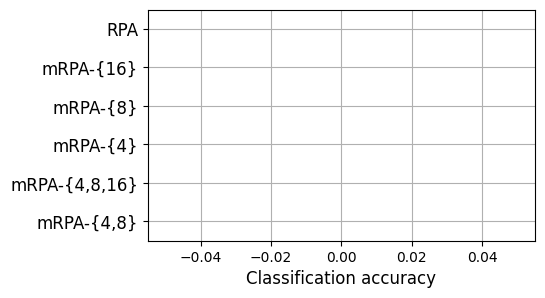

Processing tslr under cross-session scenraio...


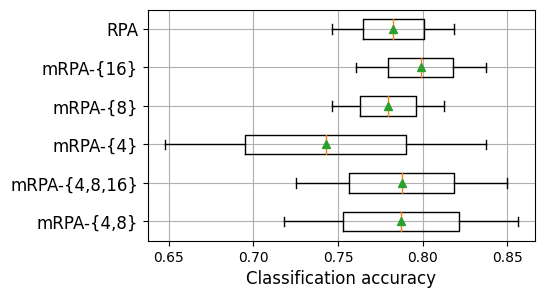

Processing csp+lr under cross-session scenraio...


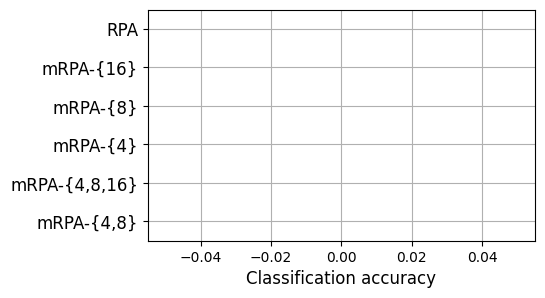

Processing csp+optsvm under cross-session scenraio...


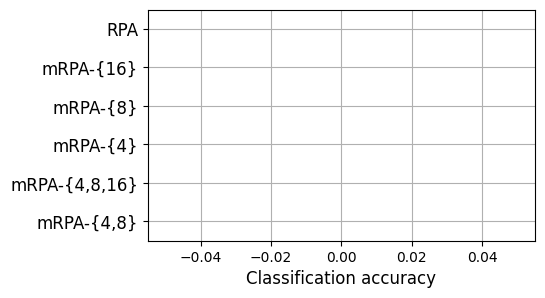

Processing fucone under cross-session scenraio...


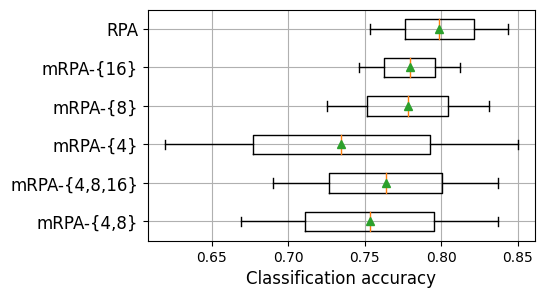

Processing mdm under within-subject scenraio...


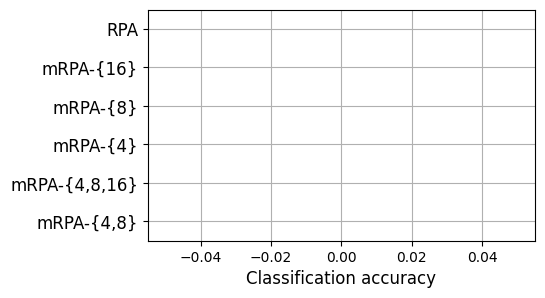

Processing tslr under within-subject scenraio...


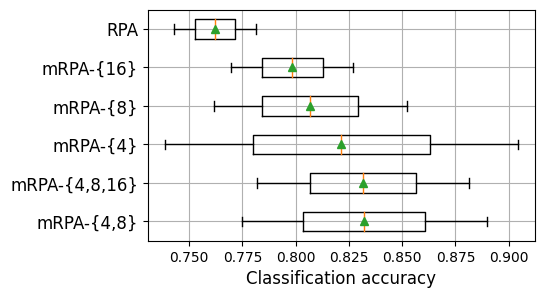

Processing csp+lr under within-subject scenraio...


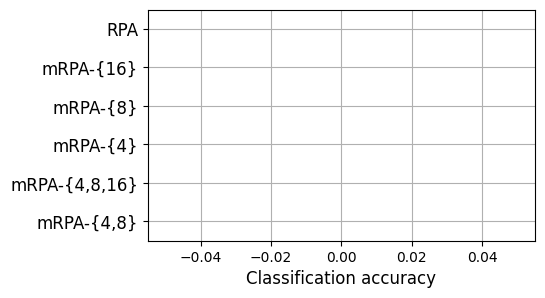

Processing csp+optsvm under within-subject scenraio...


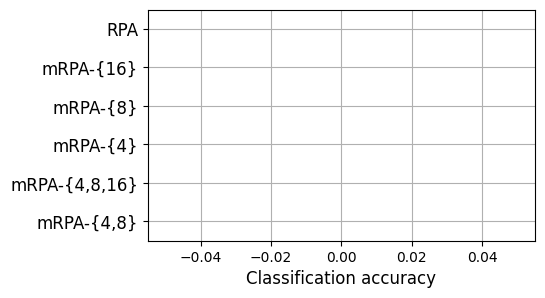

Processing fucone under within-subject scenraio...


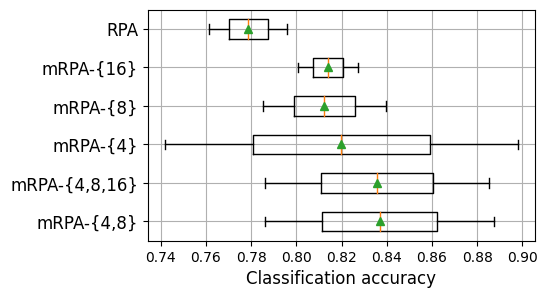

Processing mdm under cross-subject scenraio...


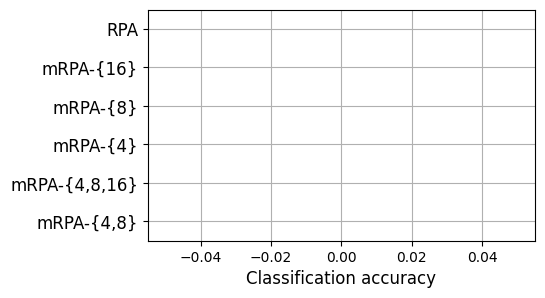

Processing tslr under cross-subject scenraio...


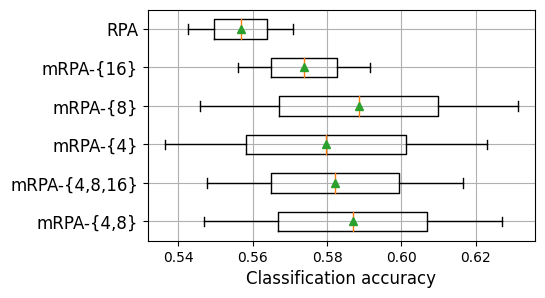

Processing csp+lr under cross-subject scenraio...


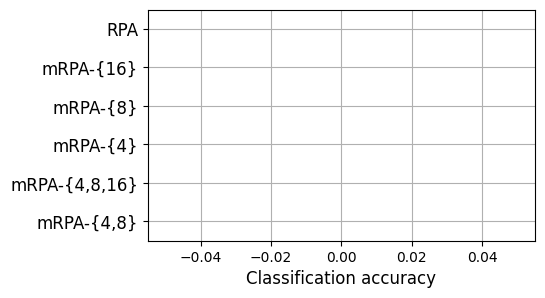

Processing csp+optsvm under cross-subject scenraio...


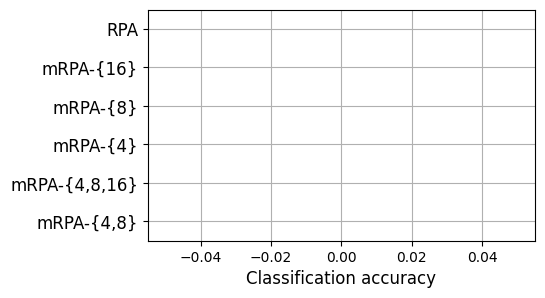

Processing fucone under cross-subject scenraio...


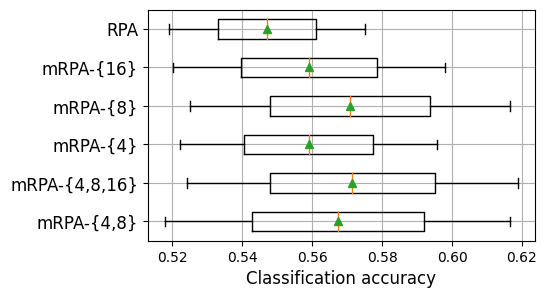

In [35]:
print("Subject: ", subjects)
print("Session: ", sessions)

for scenario in cv_list.keys():
    for algo in decoding_algo:
        print(f"Summary for {algo} under {scenario} scenario: ")
        for m in align_methods:
            print(f"mDA name: {m}")
            print("Average: ", np.mean(overall_acc[scenario][m][algo]))
            print("Std: ", np.std(overall_acc[scenario][m][algo]))
        
for scenario in cv_list.keys():
    for algo in overall_acc[scenario][align_methods[0]]:
        print(f"Processing {algo} under {scenario} scenraio...")
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.boxplot(x=[overall_acc[scenario][m][algo] for m in align_methods[:]], 
                   showmeans=True, showfliers=False, vert=False)
        #ax.set_yticklabels(['mRCT-{4,8}', 'mRCT-{4,8,16}', 'mRCT-{4}', 'mRCT-{8}', 'mRCT-{16}', 'RCT',
        #                    'mRPA-{4,8}', 'mRPA-{4,8,16}', 'mRPA-{4}', 'mRPA-{8}', 'mRPA-{16}', 'RPA'], fontsize=12)
        ax.set_yticklabels(['mRPA-{4,8}', 'mRPA-{4,8,16}', 'mRPA-{4}', 'mRPA-{8}', 'mRPA-{16}', 'RPA'], fontsize=12)
        ax.set_xlabel('Classification accuracy', fontsize=12)
        plt.grid()
        plt.savefig(f"w_k_{scenario}_{algo}.pdf", bbox_inches='tight')
        plt.show()